In [1]:
pip install mesa==0.8.7

Note: you may need to restart the kernel to use updated packages.


20it [00:06,  3.22it/s]
20it [00:07,  2.77it/s]
20it [00:06,  3.03it/s]
20it [00:06,  3.00it/s]
20it [00:03,  5.04it/s]
20it [00:06,  3.19it/s]
20it [00:07,  2.75it/s]
20it [00:07,  2.70it/s]
20it [00:06,  3.16it/s]
20it [00:08,  2.43it/s]
20it [00:03,  5.06it/s]
20it [00:07,  2.74it/s]
20it [00:10,  1.84it/s]
20it [00:11,  1.74it/s]
20it [00:10,  1.84it/s]
20it [00:10,  1.82it/s]
20it [00:07,  2.81it/s]
20it [00:10,  1.83it/s]
20it [00:10,  1.82it/s]
20it [00:11,  1.72it/s]
20it [00:10,  1.84it/s]
20it [00:10,  1.88it/s]
20it [00:07,  2.82it/s]
20it [00:12,  1.66it/s]
C:\Users\47324\AppData\Local\Temp\ipykernel_28368\3246120410.py:86: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  x = df.groupby(var).mean().reset_index()[var]
C:\Users\47324\AppData\Local\Temp\ipykernel_28368\3246120410.py:87: Fut

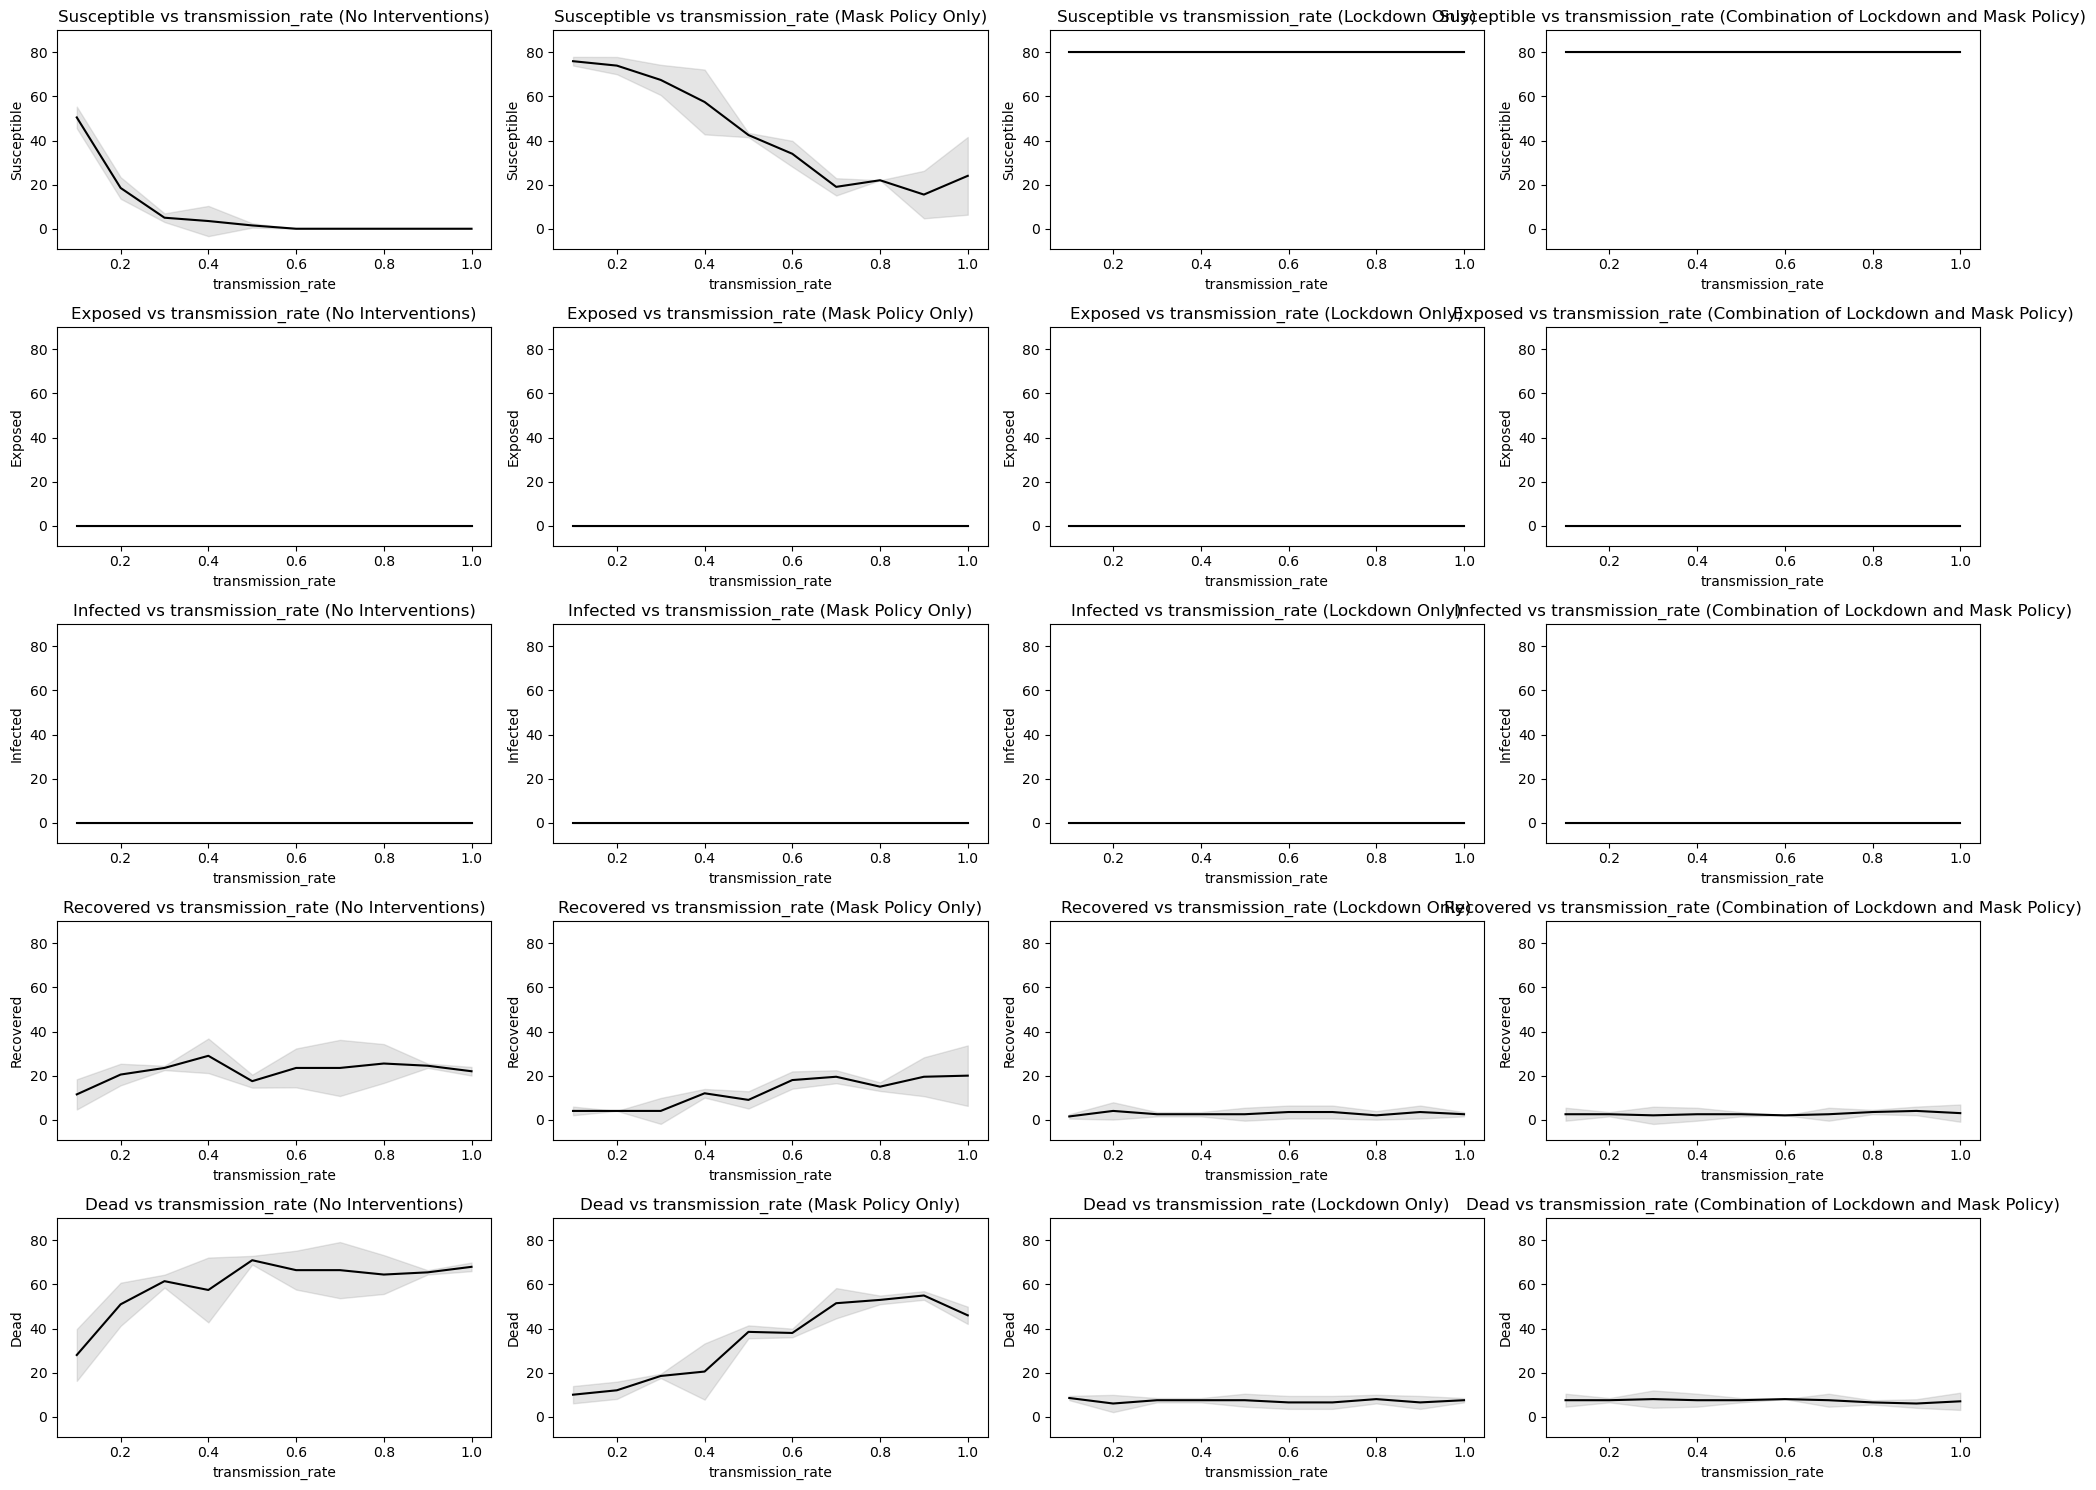

C:\Users\47324\AppData\Local\Temp\ipykernel_28368\3246120410.py:86: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  x = df.groupby(var).mean().reset_index()[var]
C:\Users\47324\AppData\Local\Temp\ipykernel_28368\3246120410.py:87: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  y = df.groupby(var).mean()[param]
C:\Users\47324\AppData\Local\Temp\ipykernel_28368\3246120410.py:86: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
 

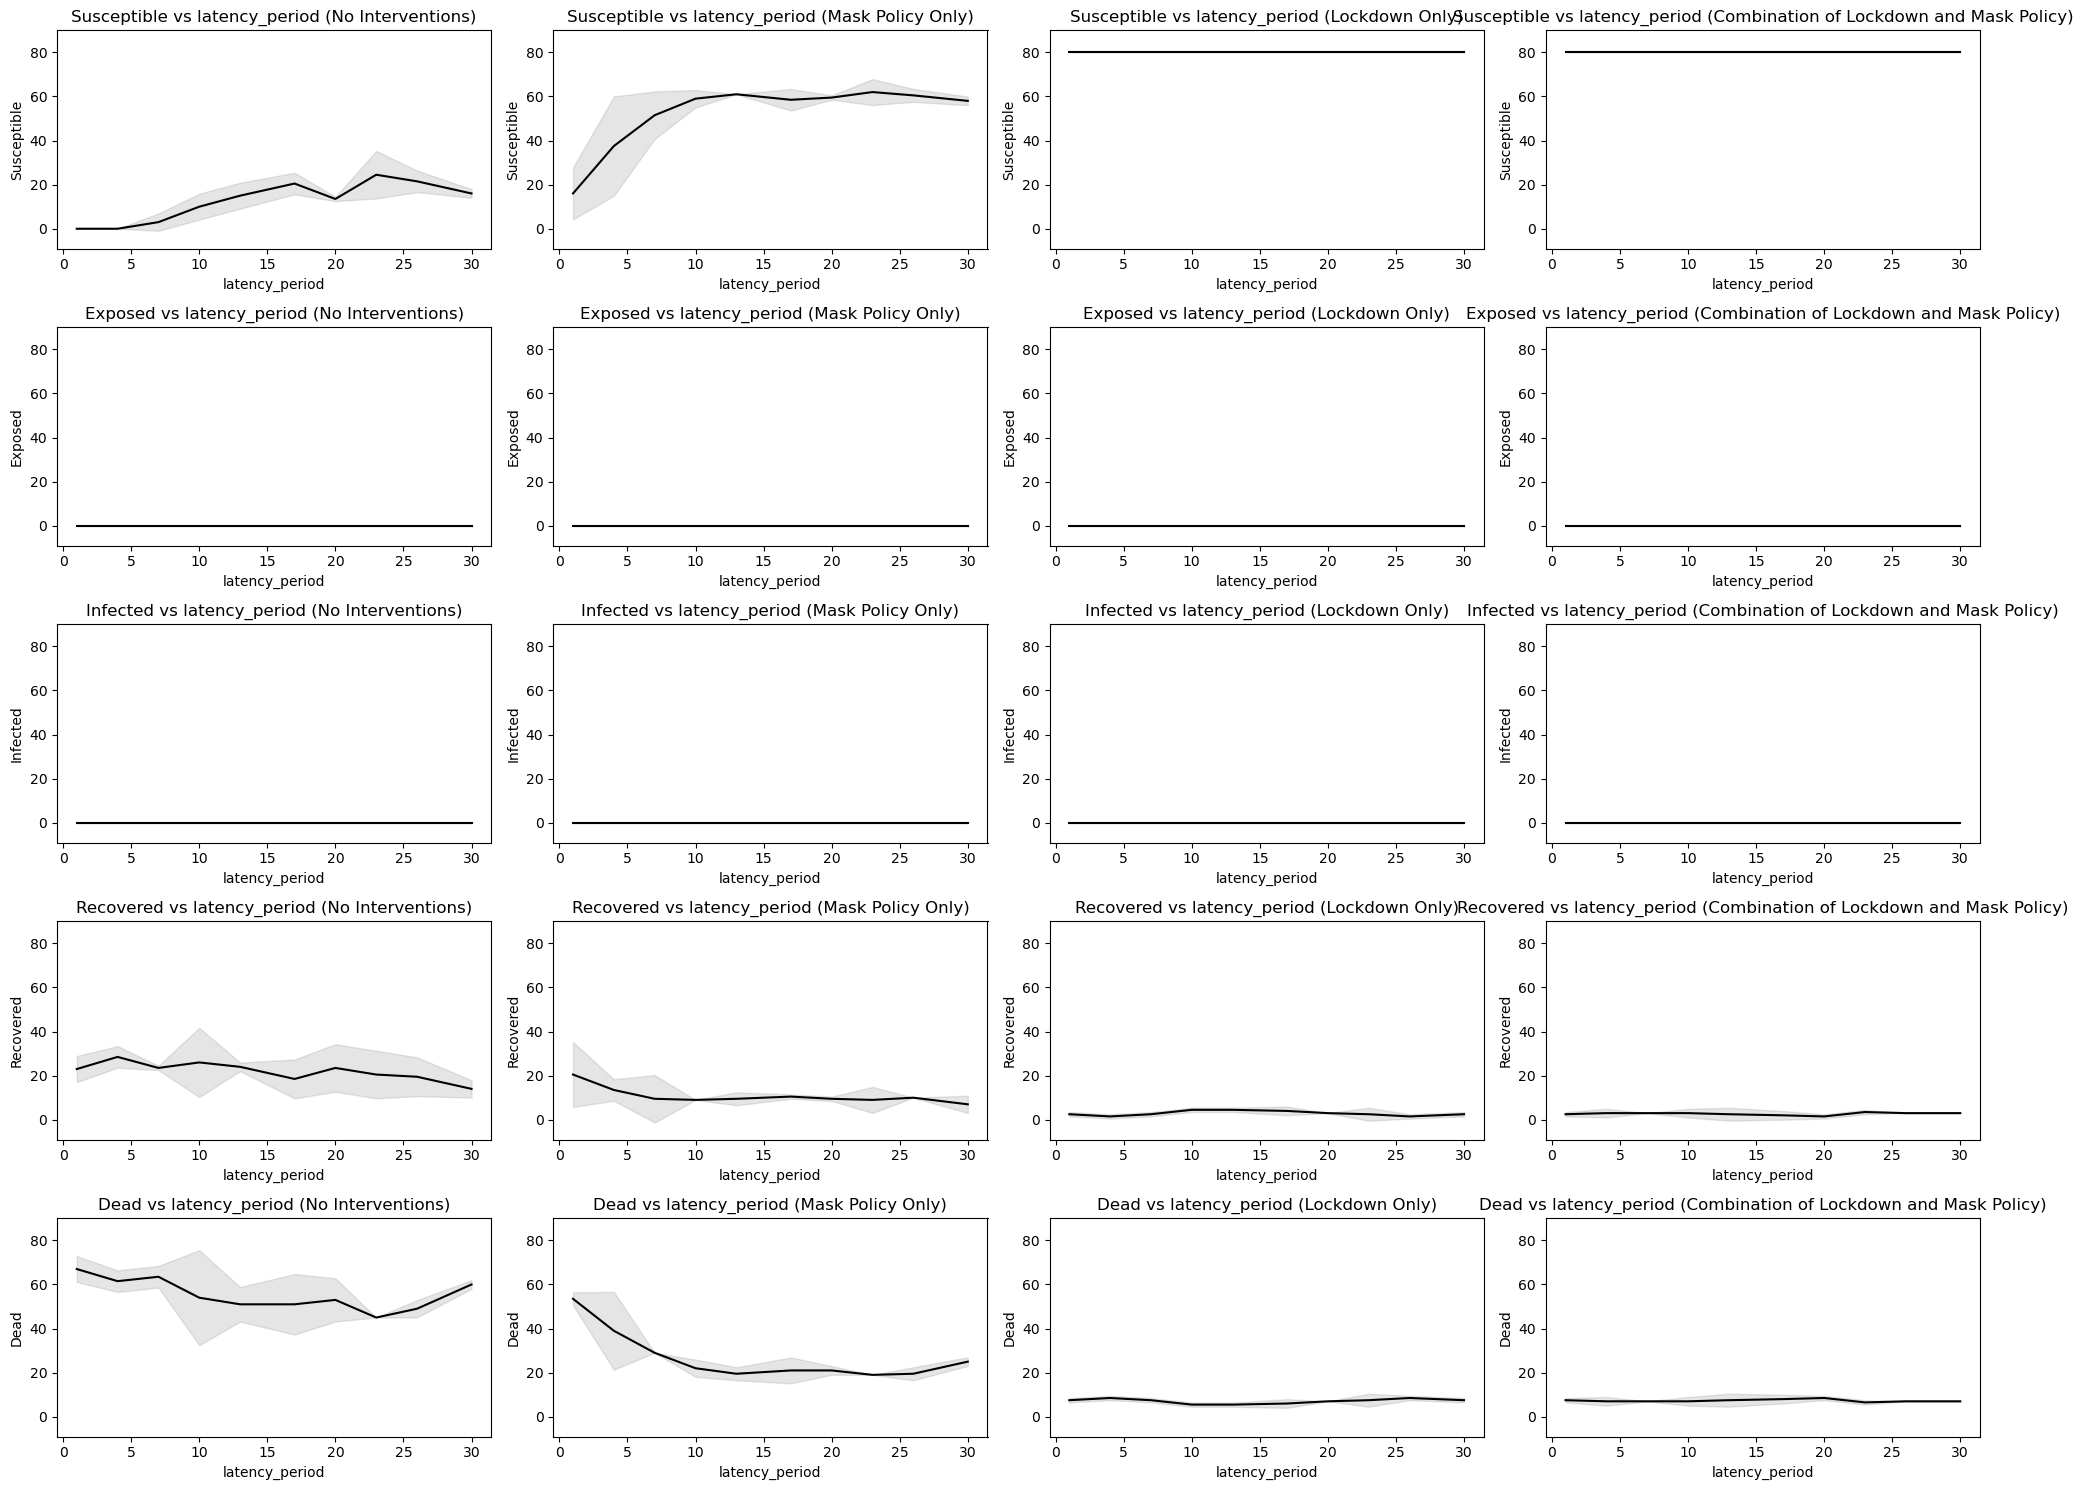

C:\Users\47324\AppData\Local\Temp\ipykernel_28368\3246120410.py:86: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  x = df.groupby(var).mean().reset_index()[var]
C:\Users\47324\AppData\Local\Temp\ipykernel_28368\3246120410.py:87: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  y = df.groupby(var).mean()[param]
C:\Users\47324\AppData\Local\Temp\ipykernel_28368\3246120410.py:86: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
 

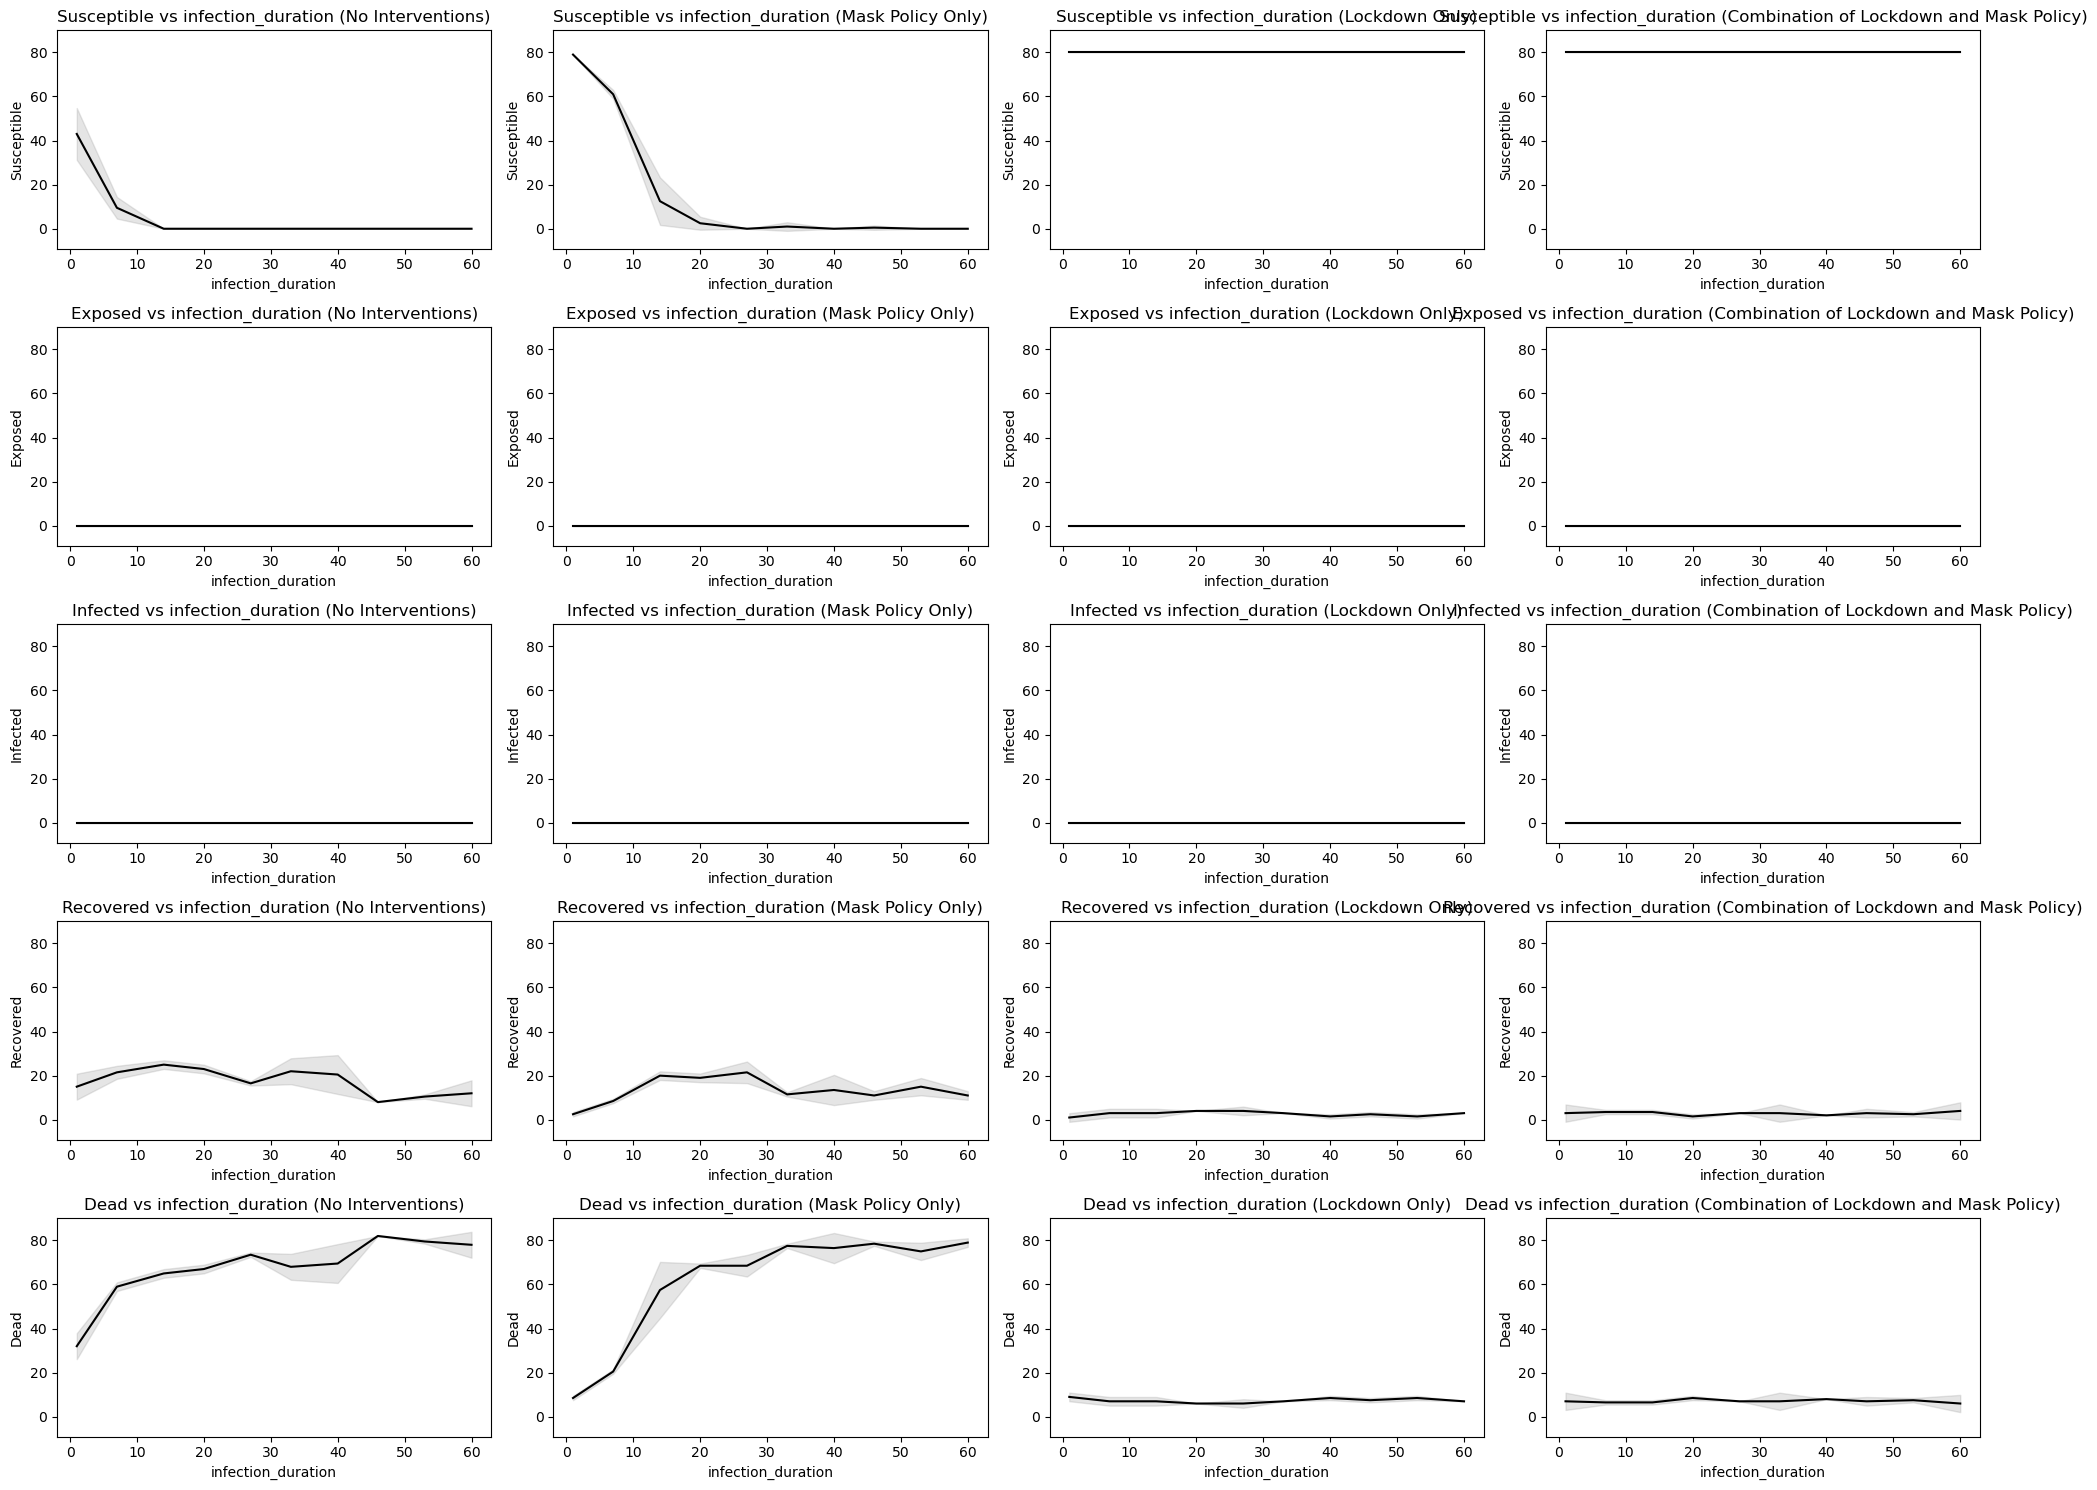

C:\Users\47324\AppData\Local\Temp\ipykernel_28368\3246120410.py:86: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  x = df.groupby(var).mean().reset_index()[var]
C:\Users\47324\AppData\Local\Temp\ipykernel_28368\3246120410.py:87: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  y = df.groupby(var).mean()[param]
C:\Users\47324\AppData\Local\Temp\ipykernel_28368\3246120410.py:86: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
 

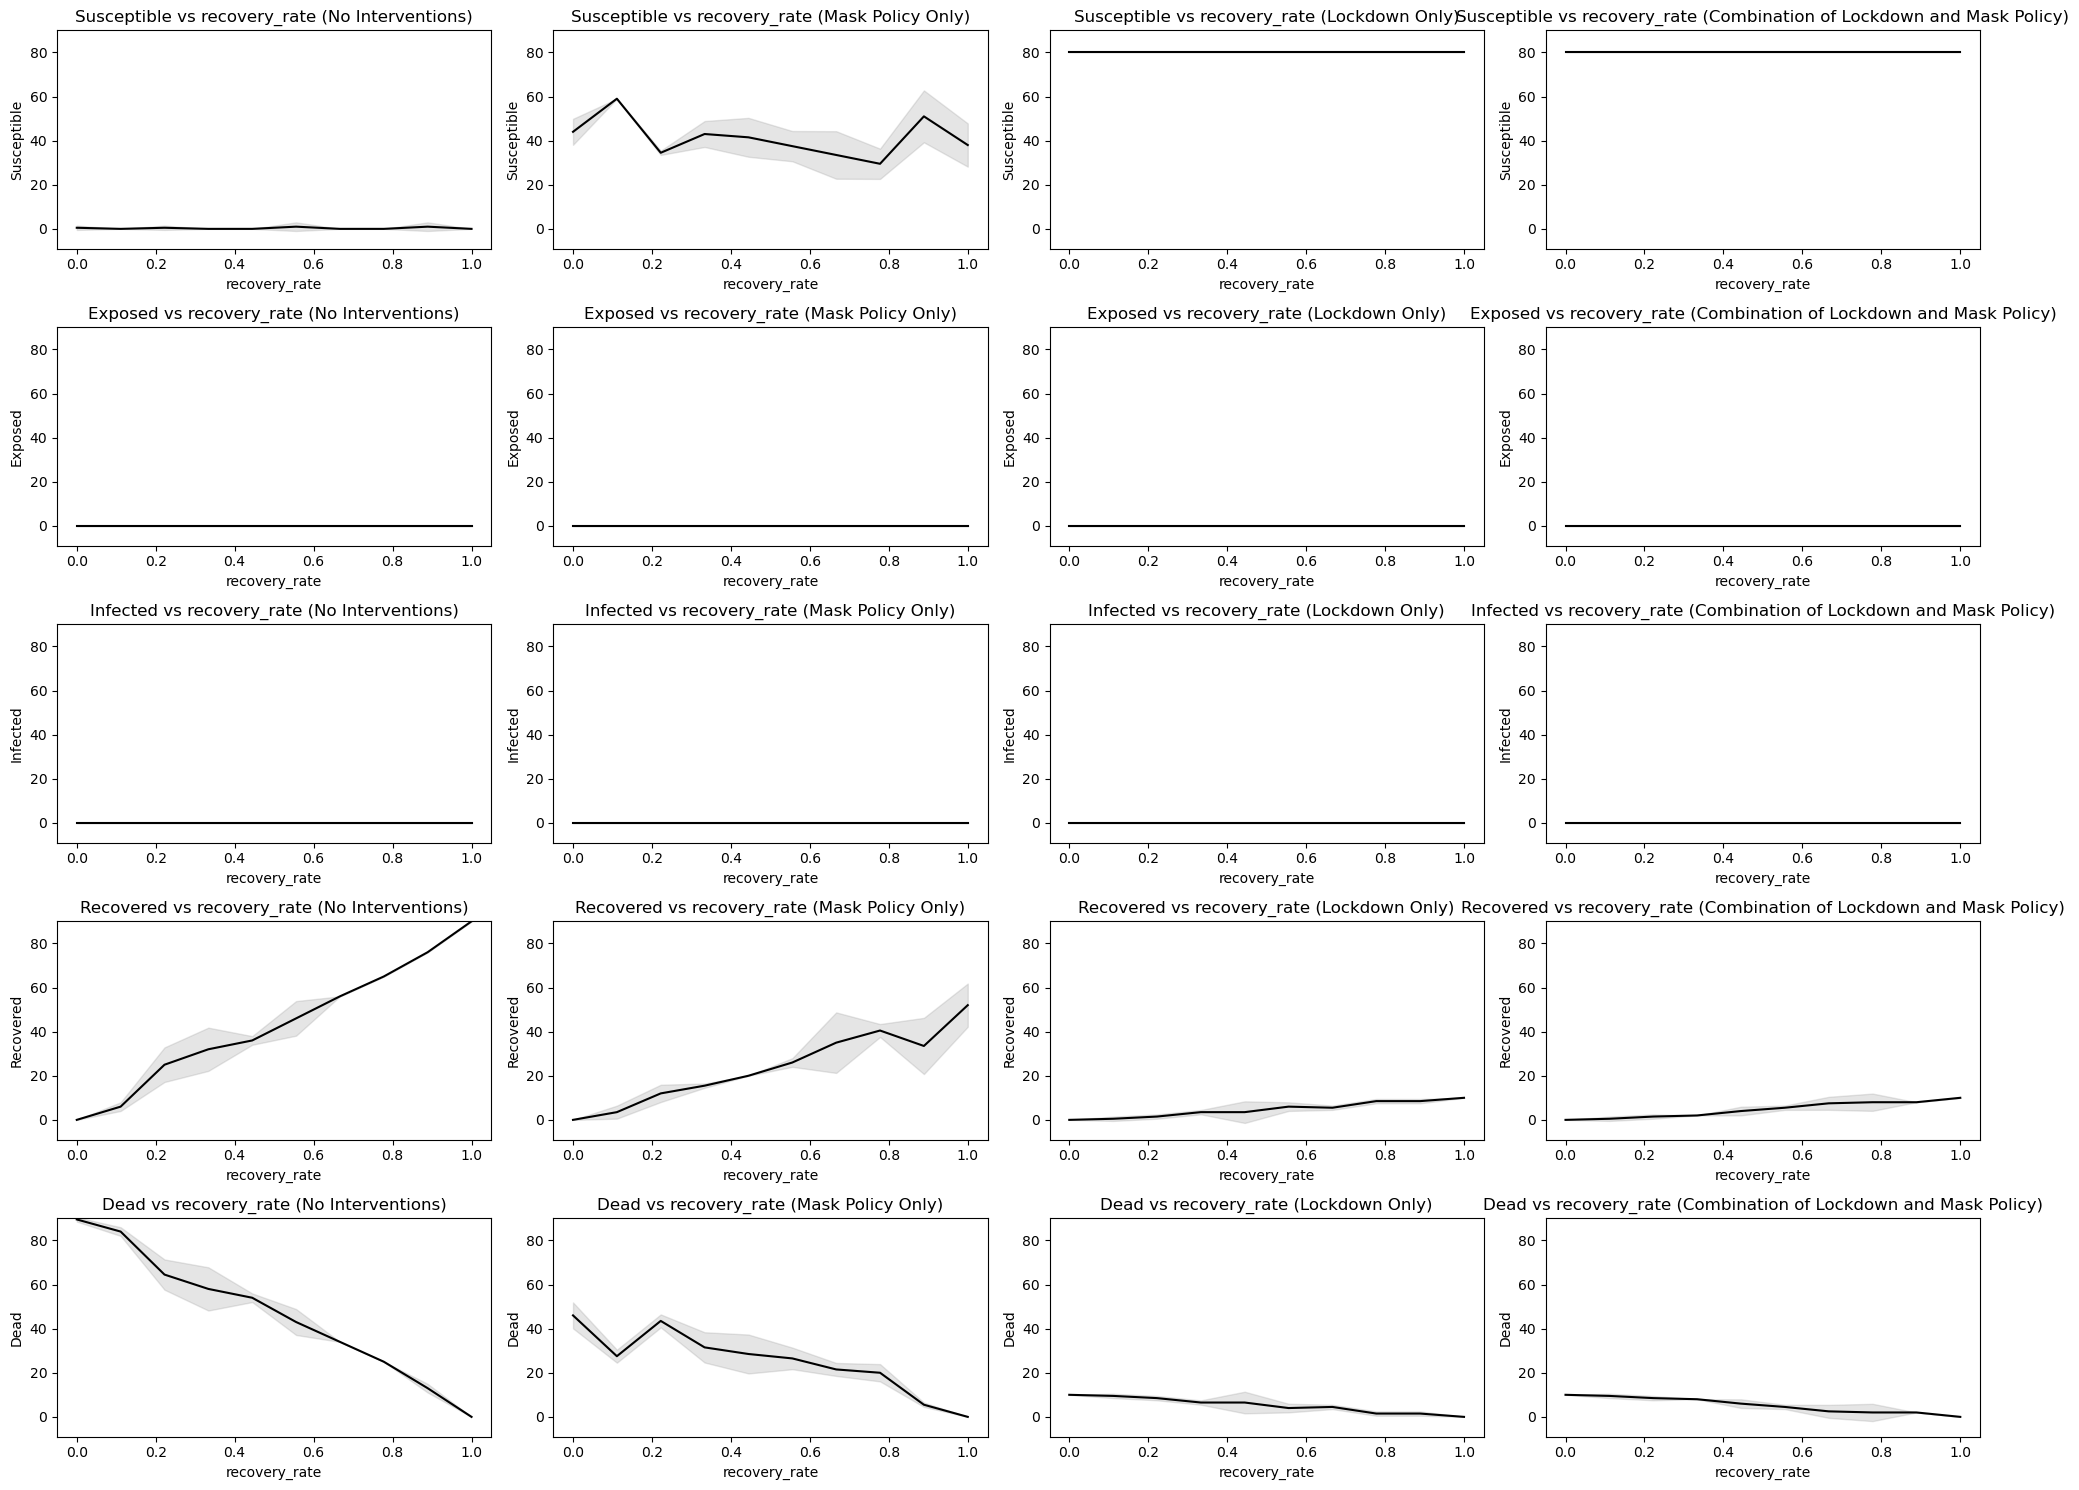

C:\Users\47324\AppData\Local\Temp\ipykernel_28368\3246120410.py:86: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  x = df.groupby(var).mean().reset_index()[var]
C:\Users\47324\AppData\Local\Temp\ipykernel_28368\3246120410.py:87: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  y = df.groupby(var).mean()[param]
C:\Users\47324\AppData\Local\Temp\ipykernel_28368\3246120410.py:86: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
 

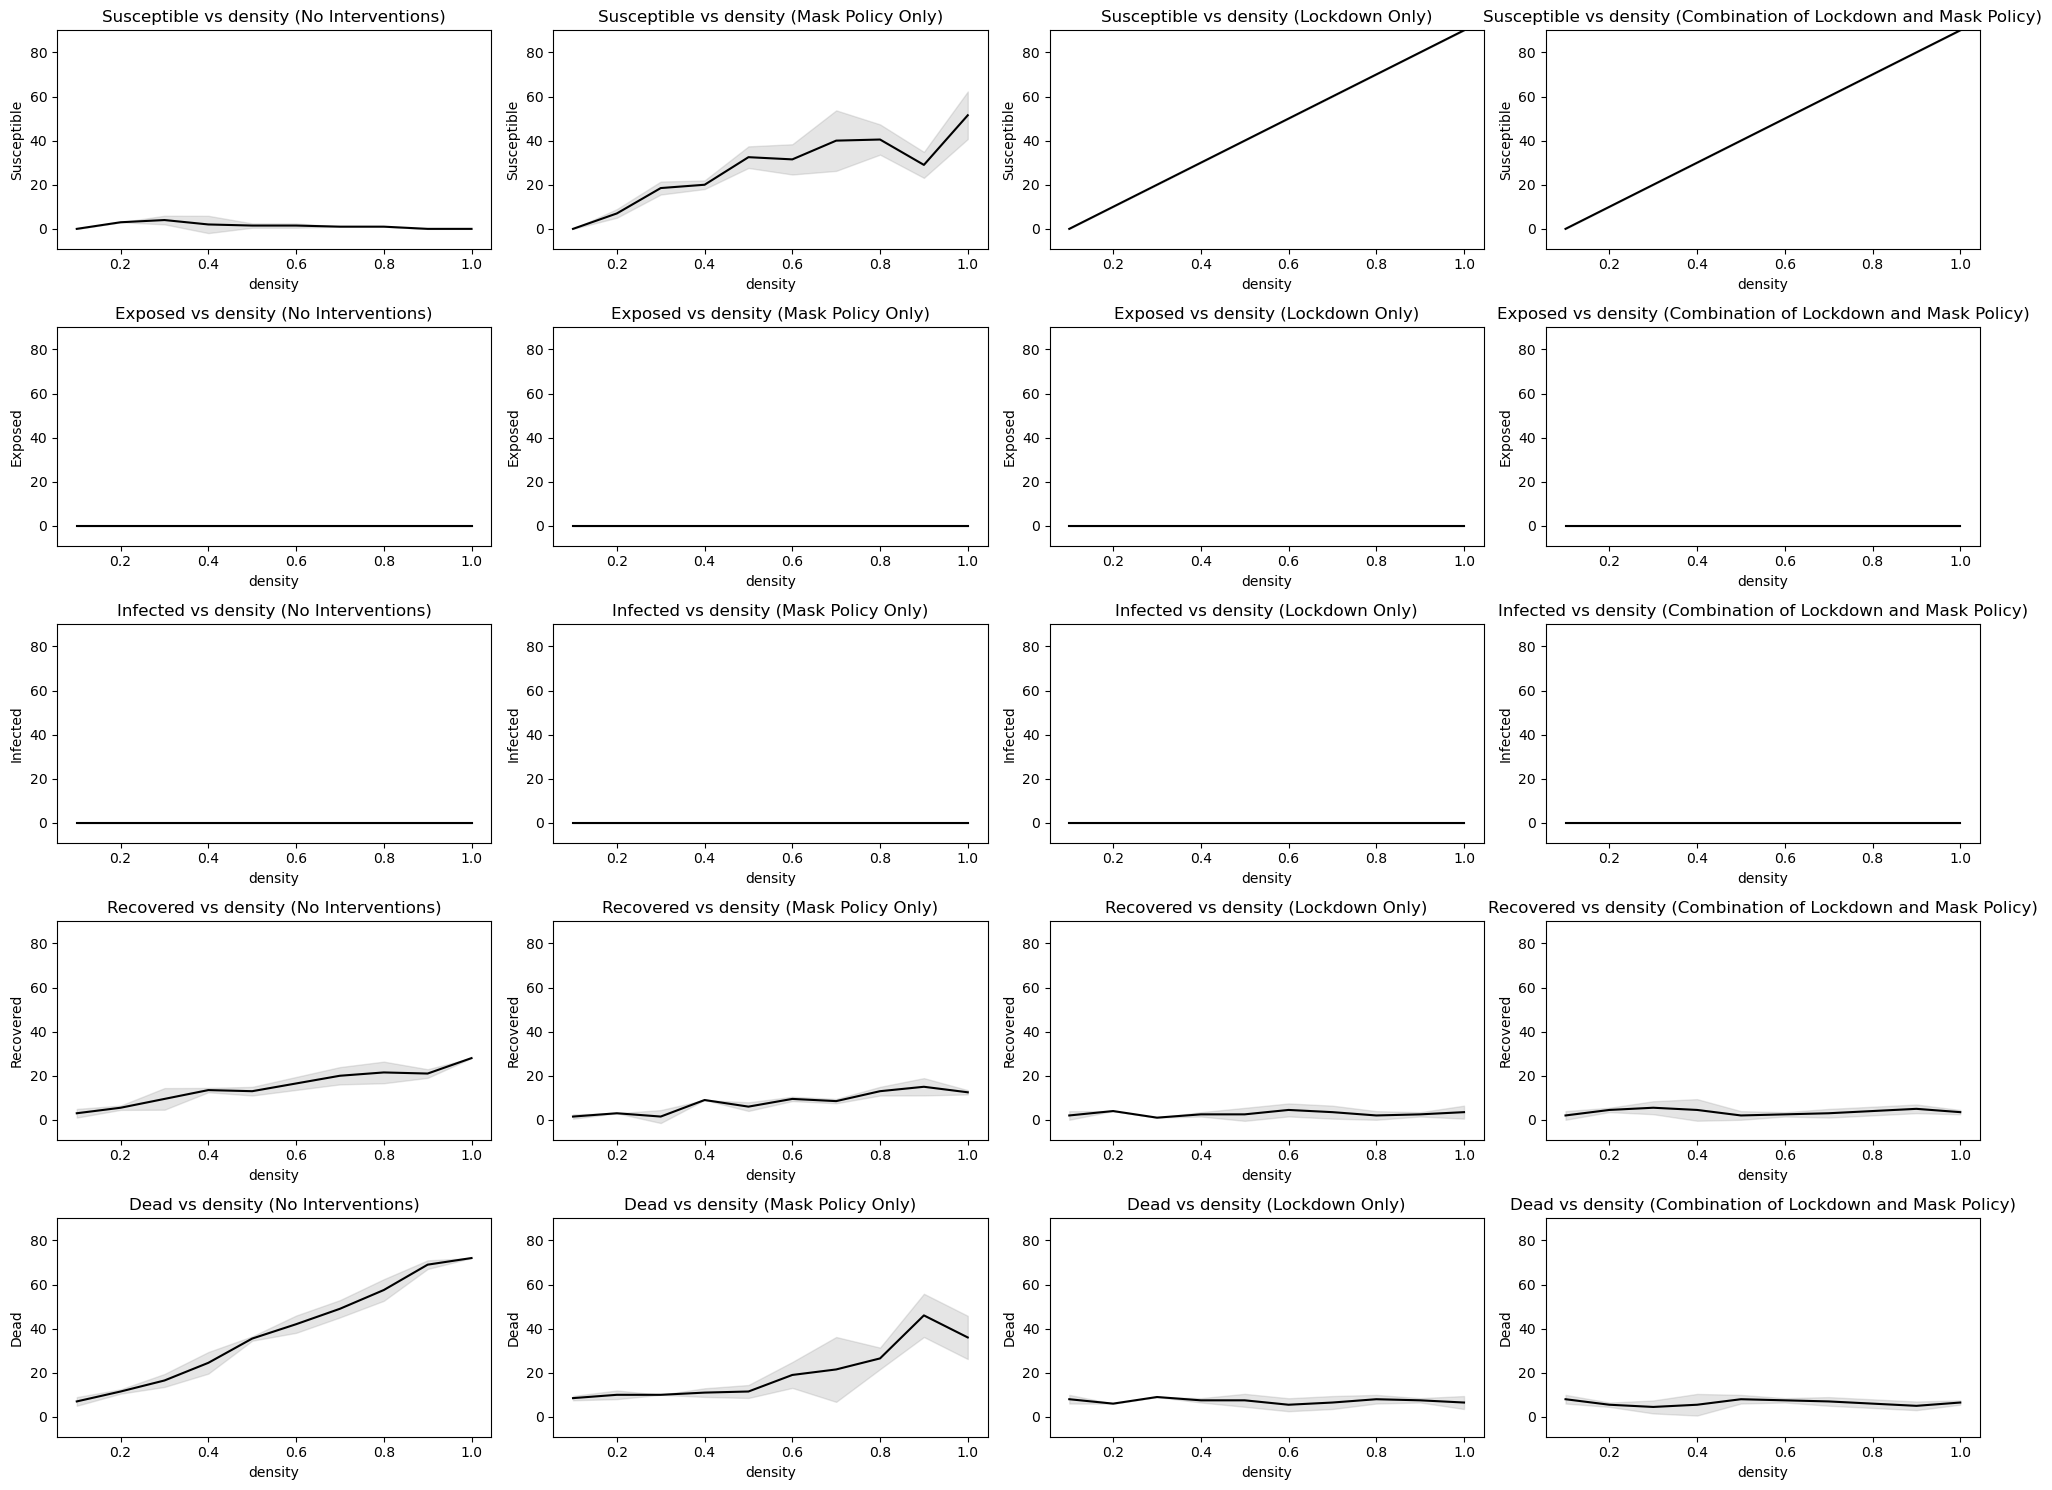

C:\Users\47324\AppData\Local\Temp\ipykernel_28368\3246120410.py:86: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  x = df.groupby(var).mean().reset_index()[var]
C:\Users\47324\AppData\Local\Temp\ipykernel_28368\3246120410.py:87: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  y = df.groupby(var).mean()[param]
C:\Users\47324\AppData\Local\Temp\ipykernel_28368\3246120410.py:86: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
 

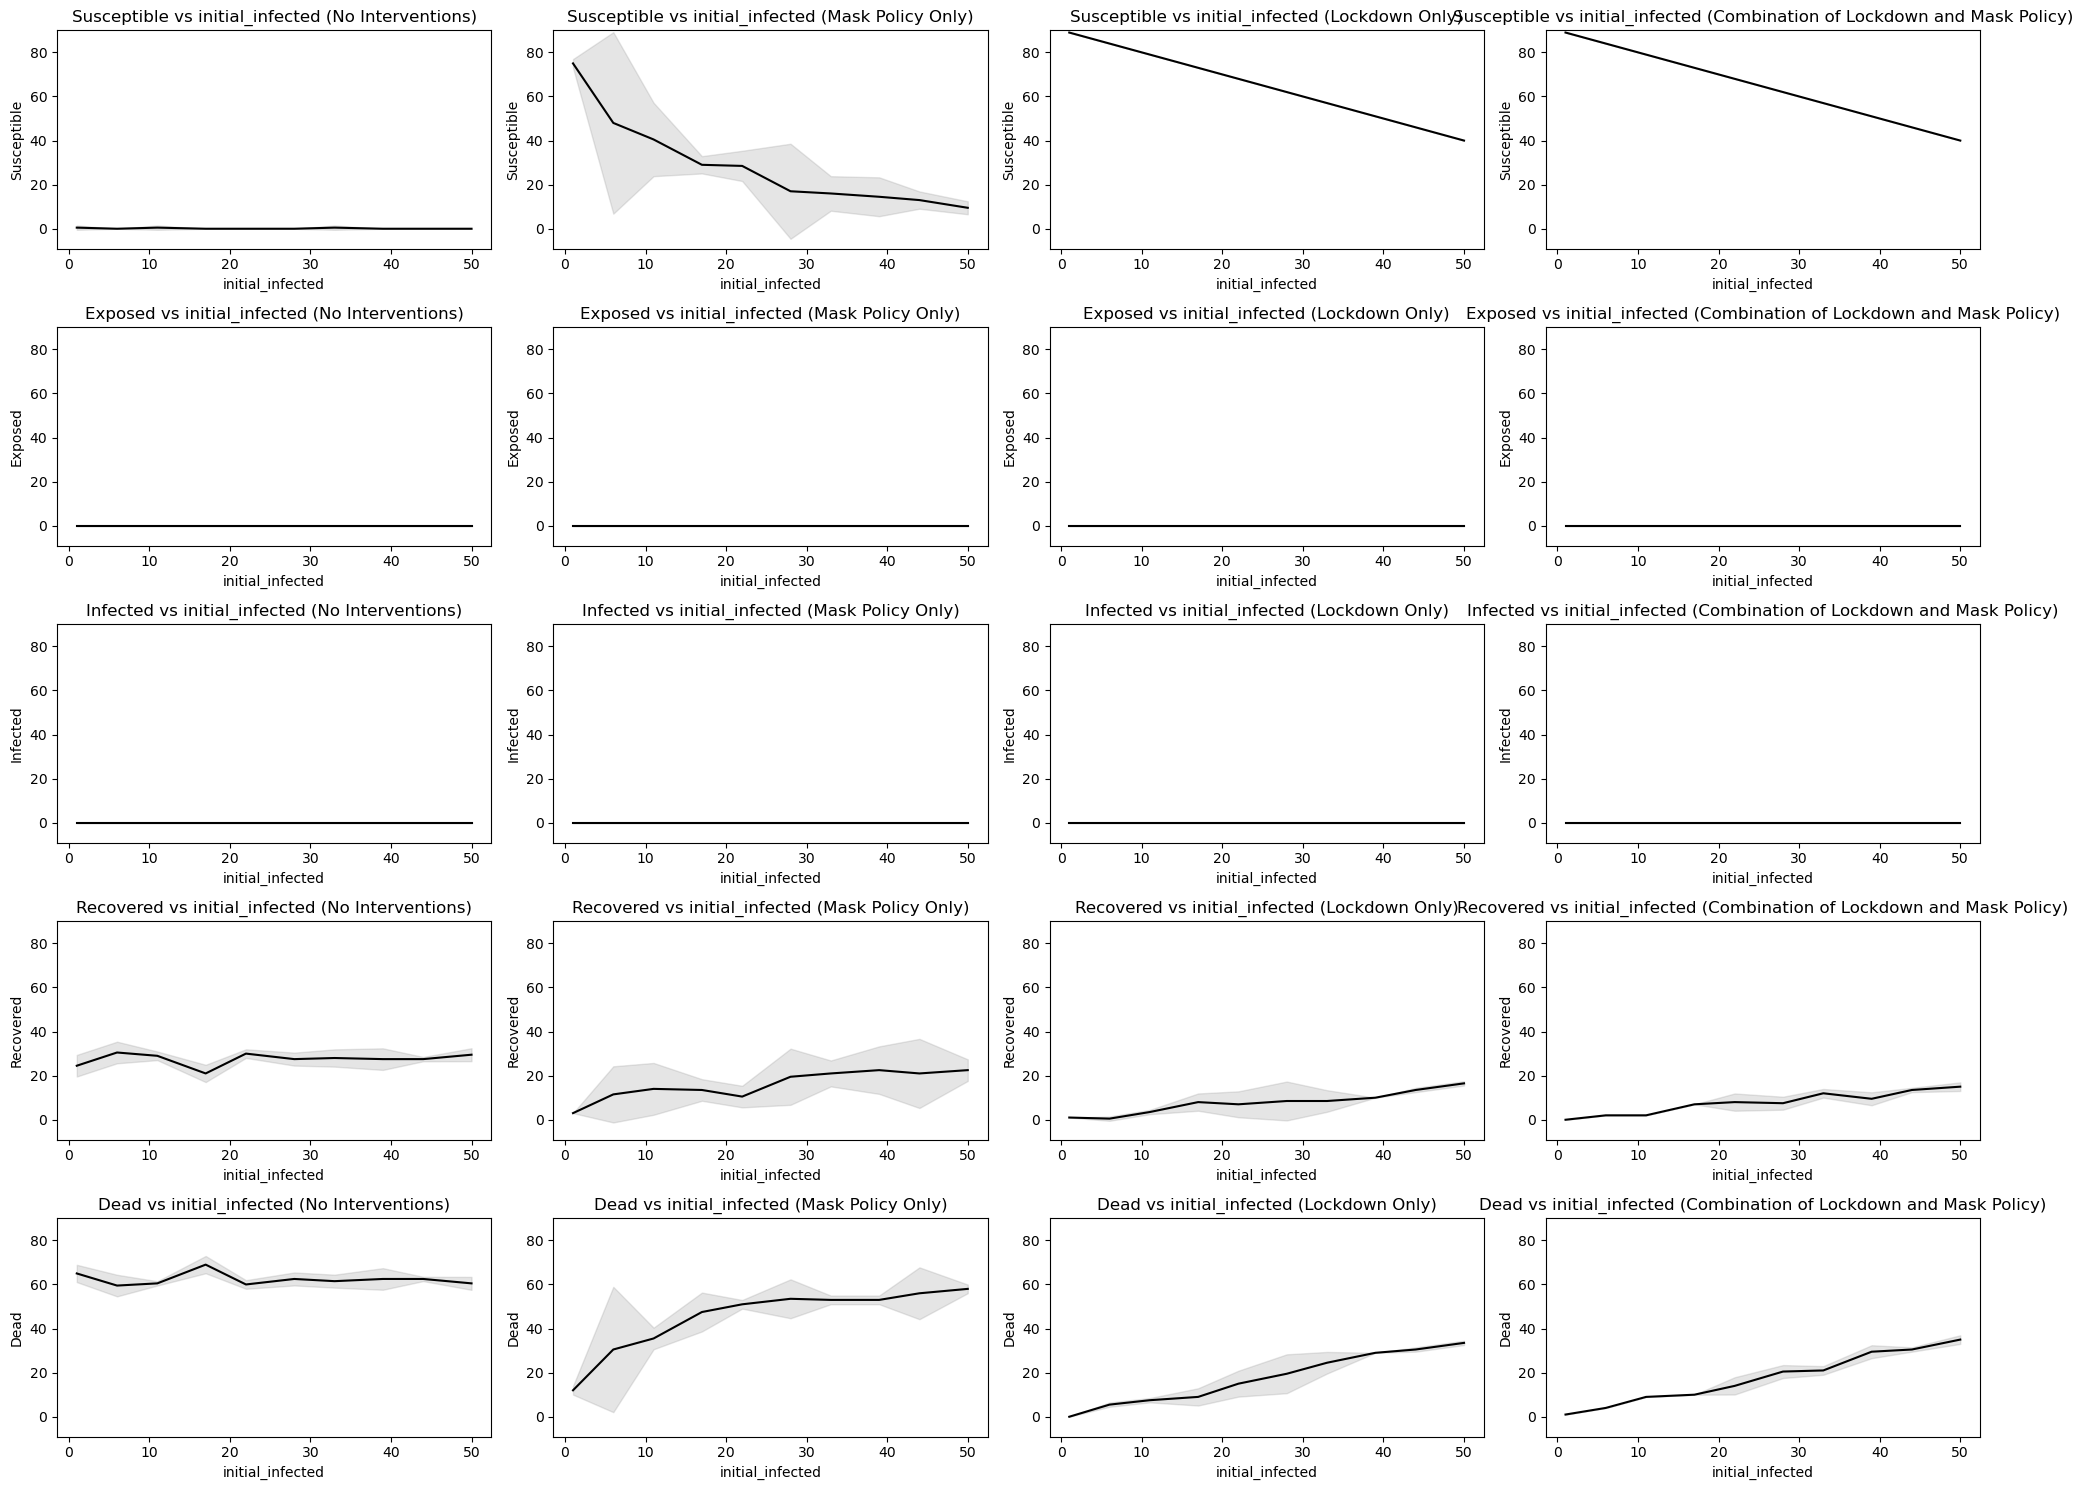

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mesa.batchrunner import BatchRunner
from Environment import SIERDModel

class CustomBatchRunner(BatchRunner):
    def run_model(self, model):
        for _ in range(self.max_steps):
            model.step()

# Define variables and bounds
problem = {
    'num_vars': 6,
    'names': ['transmission_rate', 'latency_period', 'infection_duration', 'recovery_rate', 'density', 'initial_infected'],
    'bounds': [[0.1, 1.0], [1, 30], [1, 60], [0.0, 1.0], [0.1, 1.0], [1, 50]]
}

# Set repetitions, steps, and distinct values per variable
replicates = 2
max_steps = 500
distinct_samples = 10

# Default density value
default_density = 0.9

# Calculate total number of agents based on default density
width = 10
height = 10
total_agents = width * height * default_density

# Correcting model_reporters to pass the correct arguments
model_reporters = {
    "Susceptible": lambda m: m.count_state(m, "Susceptible"),
    "Exposed": lambda m: m.count_state(m, "Exposed"),
    "Infected": lambda m: m.count_state(m, "Infected"),
    "Recovered": lambda m: m.count_state(m, "Recovered"),
    "Dead": lambda m: m.count_state(m, "Dead")
}

policies = ["No Interventions", "Mask Policy Only", "Lockdown Only", "Combination of Lockdown and Mask Policy"]
data = {policy: {} for policy in policies}

for policy in policies:
    for i, var in enumerate(problem['names']):
        samples = np.linspace(*problem['bounds'][i], num=distinct_samples)
        
        if var in ['latency_period', 'infection_duration', 'initial_infected']:
            samples = np.linspace(*problem['bounds'][i], num=distinct_samples, dtype=int)
        
        variable_parameters = {var: samples.tolist()}
        fixed_parameters = {
            "width": width,
            "height": height,
            "density": default_density,
            "transmission_rate": 0.6,
            "latency_period": 5,
            "infection_duration": 10,
            "recovery_rate": 0.3,
            "policy": policy,
            "num_districts": 5,
            "initial_infected": 10
        }

        # Ensure the specific variable parameter is updated in fixed_parameters
        del fixed_parameters[var]
        
        batch = CustomBatchRunner(
            SIERDModel,
            max_steps=max_steps,
            iterations=replicates,
            variable_parameters=variable_parameters,
            fixed_parameters=fixed_parameters,
            model_reporters=model_reporters
        )
        
        batch.run_all()
        
        data[policy][var] = batch.get_model_vars_dataframe()

# Plotting function for the current variable
def plot_current_var(df_dict, var, total_agents):
    f, axs = plt.subplots(len(model_reporters), len(df_dict), figsize=(20, 15))
    for i, (param, _) in enumerate(model_reporters.items()):
        for j, (policy, df) in enumerate(df_dict.items()):
            x = df.groupby(var).mean().reset_index()[var]
            y = df.groupby(var).mean()[param]

            replicates = df.groupby(var)[param].count()
            err = (1.96 * df.groupby(var)[param].std()) / np.sqrt(replicates)

            axs[i, j].plot(x, y, c='k')
            axs[i, j].fill_between(x, y - err, y + err, color='gray', alpha=0.2)

            axs[i, j].set_xlabel(var)
            axs[i, j].set_ylabel(param)
            axs[i, j].set_ylim(bottom=-0.1 * total_agents, top=total_agents)  # Ensure y-axis starts just below zero and ends at total agents
            axs[i, j].set_title(f'{param} vs {var} ({policy})')
    
    plt.tight_layout()
    plt.show()

# Plot for each variable
for var in problem['names']:
    df_dict = {policy: data[policy][var] for policy in policies}
    plot_current_var(df_dict, var, total_agents)
